# Privacy-preserving machine learning 
## Using homomorphic encryption over the titanic challenge

Author:

Arthur Pignet - apignet@equancy.com
    

### Objectives
This notebook aims to demonstrate the faisibility of private machine learning.

We aim to create a model that predicts which passengers survived the Titanic shipwreck. We initialy have a datase which contains the details of a subset of the passengers on board (891 to be exact) and importantly, will reveal whether they survived or not. As the Titanic was an european ship, these data are under the GRPD reglementation. 

Therefore the problematic is how can we apply machine learning to these private data without seeing them.

A part of the answer relies in homomorphic encryption. This kind of encryption allows one to make computation on encrypted data, without decrypting it, to obtain encrypted result. 

A common classification algorithm is logistic regression. Here, we will first process the data, as detailled in the notebook Appendix A, then encrypte them. We will train 3 logisitc regression, one with the state-of-the-art logistic regression from scikit-learn, one from a homemade (basic) logistique regression over unencrypted data, and the same homemade logistic regression, this time over encrypted data. 

Both homemade logistic regression can be found in the src/models repository.

## Setup 

All modules are mandatory. Make sure to import them all by running the cell below

In [1]:
import logging
import os
import sys
import time

import numpy as np
import pandas as pd
import tenseal as ts

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score
                           
os.chdir("/home/apignet/homomorphic-encryption/ckks_titanic/")
from src.features import build_features
from src.models import encrypted_LR
from src.models import unencrypted_LR

In [2]:
%load_ext memory_profiler

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
1

1

# Definition of parameters

### Paths

In [5]:
WORKING_DIR = os.getcwd()
DATA_PATH = WORKING_DIR+"/data/raw/"  
SUBMISSION_PATH = WORKING_DIR+"/report/submission/"# whole data set
#DATA_PATH = WORKING_DIR+"/data/quick_demo/"   # subset of the data set, with 15 train_samples and 5 test_samples

LOG_PATH = WORKING_DIR+"/reports/log/"
LOG_FILENAME = "0804"

### Log 

In [6]:
fileHandler = logging.FileHandler("{0}/{1}.log".format(LOG_PATH, LOG_FILENAME))
streamHandler = logging.StreamHandler(sys.stdout)
logging.basicConfig(format="%(asctime)s  [%(levelname)-8.8s]  %(message)s", 
                    datefmt='%m/%d/%Y %I:%M:%S %p', 
                    level = logging.INFO, 
                    handlers=[fileHandler, streamHandler]
                   )

### Training variables
Here we choose the training parameters. The epoch number, learning rate, are set for a classic gradient descent. The regularization rate is a multiplicative factor of the l2 norm of the weight in the loss. This regularization is really important, as we will see later. 
Every VERBOSE epoch, the loss will be computed and stored. Note that it is really time consuming
Every SAVE_WEIGHT epoch, the weight will be stored. This is usefull for debug, and monitoring the encryption/decrytion precision (which can be really bad if the safety parameters are not set properly by Bob).
N_JOBS defines the number of processes which will be created and splitted on cores. A good setting is the number of processeurs.

In [6]:
EPOCH = 40
LEARNING_RATE = 0.9
MOMENTUM_RATE = 0.6
REGULARIZATION_RATE = 0.5
VERBOSE = 4
SAVE_WEIGHT = 4
N_JOBS = 8

## Static functions

In [7]:
def crytp_array(X, local_context):
    """
    This function encrypt a list of vector
    
    :parameters 
    ------------
    
    :param X ; list of list, interpreted as list of vector to encrypt
    :param local_context ; TenSEAL context object used to encrypt
    
    :returns
    ------------
    
    list ; list of CKKS ciphertext  
    
    """
    res = []
    for i in range(len(X)):
        res.append(ts.ckks_vector(local_context, X[i]))
        if i == len(X) // 4:
            logging.info("25 % ...")
        elif i == len(X) // 2 :
            logging.info("50 % ...")
        elif i == 3* len(X)//4:
            logging.info("75% ...")
    return res

### Confidential functions

These functions involves security breachs (as use of unencrypted data, or decryption of weights) and cannot be coded by Alice.
However, the functions encapslulate the unsafe process, so can be performed by Alice if Bob provides them. 
Therefore, they are currently passed as parameters to Alice, which only calls them.

Currently there is a huge security breach, as confidential parameters (security key for instance), which are needed by those functions, are passed in a dictionnary to Alice. 
For a safe protocole, we have to change these functions, to set up a safe communication protocole between Bob and Alice.
Alice will therefore only send the crypted data to Bob (using these functions, in which can be set up the communication process) and Bob will locally perform the functions which are currently coded bellow. 

**here we only encapsulate the safety issues into some functions. The process is not safe, but our goal is only to compare different models, to specificly analyse the impact of homomorphic encryption. For a safer protocol, see the two next notebook, with a real/physical separation between Alice and Bob**

In [8]:
def refresh(ciphertext, **kwarg):
    """
    This function is here to refresh a ciphertext. 
    This operation reset to 0 the calculus depth of the input ciphertext 
    WARNING :  Basically the function decryt and re-encrypt the ciphertext. 
    This is not safe, this operation needs to be done by a trusted part 
    (Bob for the perfect instance, 
    even if it requieres communications between Alice and Bob while training)
    
    :parameters 
    ------------
    
    ciphertext ; encrypted CKKS vector 
    **kwarg ; dict, must contain context and secret_key.
    
    :returns
    ------------
    
    ciphertext : encrypted CKKS vector 
    
    """
    context = kwarg.get("context", None)
    secret_key = kwarg.get("secret_key", None)
    assert context , "Context must be provided with the key : context"+str(context)
    if context.is_private():
        return ts.ckks_vector(context, ciphertext.decrypt())
    else : 
        if not secret_key:
            raise AttributeError("The secret key is not provided and the context provided is public,\
            decryption is not possible")
        else:
            return ts.ckks_vector(context, ciphertext.decrypt(secret_key))
   
            
def accuracy(crypted_weight, crypted_bias, 
             prior_unencrypted_X = None,
             prior_unencrypted_Y=None, 
             treshold = 0.5, verbose = True, **kwarg):
    """
    This function is here to compute the accuracy
    1-NOTE : we could maybe estimate this function homomorphically, 
    by designing an approximation of the sign function. 
    However, this kind of approximation seems really hard to set up 
    Therefore, we will not be able to use the metric, as the result is encrypted.
    2-NOTE : this function could be parallelized, as we do not need the result for the next epoch. 
    
    :parameters 
    ------------
    
    crypted_weight ; encrypted CKKS vector (size equal to the number of features)
    crypted_bias ; encrypted CKKS vector (size 1)
    (Optionnal) prior_unencrypted_X ; samples on which the model accuracy will be computed. 
                                If not provided, the accuracy will be computed with the data provided 
                                in the kwarg
    (Optionnal) prior_unencrypted_Y ; labels on which the model accuracy will be computed. If not provided.
                                If not provided, the accuracy will be computed with the data provided 
                                in the kwarg
    threshold : default 0.5, use to classified the data from the probability computed
    verbose : Default True. If set to True, will log a report on F1, recall, precision, accuracy scores, 
                            and print the confusion matrix
    **kwarg ; dict, must contain context, secret_key, 
    (Optionnal) unencrytped_X and (Optionnal) unencrypted_Y 
    
    :returns
    ------------
    
    accuray : float (rounded to 2 digits)
    
    
    """
    context = kwarg.get("context", None)
    if not context:
        raise AttributeError("Context must be provided in the **kwarg, with the key : context")
    secret_key = kwarg.get("secret_key", None)
    if prior_unencrypted_X is None:
        unencrypted_X = kwarg.get("unencrypted_X", None)
        if unencrypted_X is None:
            raise AttributeError("Unencrypted samples must be provided, either in the arguments, \
            or in the **kwarg, with the key : unencrypted_X")
    else:
        unencrypted_X = np.array(prior_unencrypted_X)
    if prior_unencrypted_Y is None:
        unencrypted_Y = kwarg.get("unencrypted_Y", None)
        if unencrypted_Y is None:
            raise AttributeError("Unencrypted labels must be provided, either in the arguments,\
            or in the **kwarg, with the key : unencrypted_Y")
    else:
        unencrypted_Y = np.array(prior_unencrypted_Y)
    if context.is_private():
            weight = np.array(crypted_weight.decrypt())
            bias = np.array(crypted_bias.decrypt())
    else : 
        if not secret_key:
            raise AttributeError("The secret key is not provided and the context provided is public,\
            decryption is not possible. Pass a private context or the secret key")
        else:
            weight = np.array(crypted_weight.decrypt(secret_key))
            bias = np.array(crypted_bias.decrypt(secret_key))
            
    
    re = unencrypted_X.dot(weight) + bias  
    prediction = (np.float_power(re, 3)) * -0.004 + re * 0.197 + 0.5
    
    prediction = (1*(prediction > treshold)).reshape((-1,1))
    recall = recall_score(test_labels,prediction)
    F1 = f1_score(test_labels, prediction)
    precision = precision_score(test_labels, prediction)
    cf_m=confusion_matrix(test_labels, prediction ) 
    accuracy = accuracy_score(test_labels, prediction)
    if verbose:
        logging.info("Precision score of encrypted model on test set: %s " % precision)
        logging.info("Recall score  of encrypted model on test set : %s " % recall)
        logging.info("F1 score of encrypted model on test set: %s " % F1)
        logging.info("Accuracy of encrypted model on train set : %s " % accuracy)
        sns.heatmap(cf_m, annot=True)
    return {'precision': precision, 
            'recall':recall, 
            'F1 score':F1, 
            "accuracy":accuracy, 
            "confusion matrix":cf_m}
    

# Loading and processing the data

As said, the detailld of the data processing, feature engineering can be found in the notebook Appendix A

In [11]:
%%memit
logging.info(os.getcwd())
raw_train, raw_test = build_features.data_import(DATA_PATH)
train, submission_test = build_features.processing(raw_train, raw_test)
#del submission_test

08/07/2020 08:35:21 AM  [INFO    ]  /home/apignet/homomorphic-encryption/ckks_titanic
08/07/2020 08:35:21 AM  [INFO    ]  loading the data into memory (pandas df)
08/07/2020 08:35:21 AM  [INFO    ]  Done
08/07/2020 08:35:21 AM  [INFO    ]  making final data set from raw data
08/07/2020 08:35:21 AM  [INFO    ]  Done
08/07/2020 08:35:21 AM  [INFO    ]  /home/apignet/homomorphic-encryption/ckks_titanic
08/07/2020 08:35:21 AM  [INFO    ]  loading the data into memory (pandas df)
08/07/2020 08:35:21 AM  [INFO    ]  Done
08/07/2020 08:35:21 AM  [INFO    ]  making final data set from raw data
08/07/2020 08:35:21 AM  [INFO    ]  Done
peak memory: 193.60 MiB, increment: 0.93 MiB


In [8]:
%%memit
train, test = train_test_split(train, test_size=0.15)
train_labels = train.Survived
test_labels = test.Survived
train_features = train.drop("Survived", axis=1)
test_features = test.drop("Survived", axis=1)

peak memory: 169.13 MiB, increment: 0.15 MiB


# Homomorphic encryption

**A FINIR**

Homomorphic encryption allowing private computations on the encrypted data, without having to decrypt its. Here Bob will encrypt the data, and will had Alice made the computation (model training). Alice will never see the plain data, and thus the dataset will stay private. Besides, this king of encryption suffers from huge draw back, as increasing memory/time complexity, and limited calculus depth per ciphertext. Indeed, for most of the homomorphic encryption (HE) schemes, the number of operation (like multiplication and addition) is limited. After performing a finite number of multiplication on a ciphertext, one will not be able to decrypt it properly. Some schemes by pass this limitation, but always at important costs, in memory or time computation. 

### Choice of the encryption scheme 

The encryption will be done with the tenseal library, which is build on the top of the Microsoft SEAL software.
The two encryption schemes avaible in SEAL are BFV and CKKS. Here, we choose to use the CKKS sheme, which is designed to made floating point operations, at the opposite of the BFV scheme, which handles only intergers. 

### Definition of safety parameters

The choice of the safety parameters (poly_modulus_degree, coeff_mod_bit_sizes, and global_scale) is cruciale. It is them that will define the memory size of our ciphertext, the floating precision of our operations, and the calculus depth limite.

A really good understanding of the CKKS scheme functionning is requiered to properly set up these parameters. 

In the CKKS scheme, the plaintext vextors are first converted into polynomials with integer coefficients, which are then map by a ring isomorphisme in the ring FORMULE ICI.

The number of slots in a ciphertext is poly_modulus_degree / 2 and each slot encodes one real or complex number. While encoding a smaller vector, the SEAL CKKSEncoder will implicitly pad itwith zeros to full size (poly_modulus_degree / 2) when encoding. Thus, the memory size of a ciphertext is definied by the poly_modulus.

Moreover, to convert the plaintext into polynomial, the floating-point coefficients of the input will be scaled up by the parameter gloabl_scale. The scale can be seen as determining the bit-precision of the encoding. The ismorphism will store our messages modulo coeff_modulus, so the scaled message must not get too close to the total size of coeff_modulus. Otherwise, the decrypted result will make no sense. Therefore, the choice of the scale will participate to the precision of our operations, and is strongly relies to the choice of the poly_modulus.  

As ciphertext multiplications are done as polynomial multiplications, we need to relinearize the polynom to obtain a result that has the same size as the initial ciphertexts (In fact this operation is not mandatory, but is done after every mutiplication in our application. See the documentation for more information). It is done with a special key (relin_key), and as a side-effect, makes the scale dramaticly increase. The scale of any ciphertext must not get too close to the total size of coeff_modulus, or else the ciphertext simply runs out of room to store the scaled-up plaintext. The CKKS scheme provides a rescale functionality that can reduce the scale, and stabilize the scale expansion. 

This rescale operation removes the last of the primes from coeff_modulus, but as a side-effect it scales down the ciphertext by the removed prime. More precisely, suppose that the scale in a CKKS ciphertext is S, and the last prime in the current coeff_modulus (for the ciphertext) is P. Rescaling to the next level changes the scale to S/P, and removes the prime P from the coeff_modulus, as usual in modulus switching. The number of primes limits how many rescalings can be done, and thus limits the multiplicative depth of the computation. It is possible to choose the initial scale freely. One good strategy can be to is to set the initial scale S and primes P_i in the coeff_modulus to be very close to each other. If ciphertexts have scale S before multiplication, they have scale S^2 after multiplication, and S^2/P_i after rescaling. If all P_i are close to S, then S^2/P_i is close to S again. This way we stabilize the scales to be close to S throughout the computation. Generally, for a circuit of depth D, we need to rescale D times, i.e., we need to be able to remove D primes from the coefficient modulus. Once we have only one prime left in the coeff_modulus, the remaining prime must be larger than S by a few bits to preserve the pre-decimal-point value of the plaintext.

sources : 
SEAL tutorials 

https://github.com/microsoft/SEAL/blob/master/native/examples/1_bfv_basics.cpp
https://github.com/microsoft/SEAL/blob/master/native/examples/2_encoders.cpp               
https://github.com/microsoft/SEAL/blob/master/native/examples/3_levels.cpp
https://github.com/microsoft/SEAL/blob/master/native/examples/4_ckks_basics.cpp

from https://github.com/microsoft/SEAL/blob/master/native/examples


In [11]:
%%memit
logging.info('Definition of safety parameters...')
timer = time.time()
# context = ts.context(ts.SCHEME_TYPE.CKKS, 32768,
# coeff_mod_bit_sizes=[60, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 60])
#context = ts.context(ts.SCHEME_TYPE.CKKS, 8192, coeff_mod_bit_sizes=[40, 21, 21, 21, 21, 21, 21, 40])

context = ts.context(ts.SCHEME_TYPE.CKKS, 16384, coeff_mod_bit_sizes=[60, 40, 40, 40, 40, 40, 40,40, 60])
context.global_scale = pow(2, 40)
logging.info("Done. " + str(round(time.time() - timer, 2)) + " seconds")


logging.info('Generation of the secret key...')
timer = time.time()
secret_key = context.secret_key()
context.make_context_public() #drop the relin keys, the galois keys, and the secret keys. 
logging.info("Done. " + str(round(time.time() - timer, 2)) + " seconds")
logging.info('Generation of the Galois Key...')
timer = time.time()
context.generate_galois_keys(secret_key)
logging.info("Done. " + str(round(time.time() - timer, 2)) + " seconds")
logging.info('Generation of the Relin Key...')
timer = time.time()
context.generate_relin_keys(secret_key)
logging.info("Done. " + str(round(time.time() - timer, 2)) + " seconds")
if context.is_public():
    logging.info("The context is now public, the context do not hold the secret key anymore, and decrypt \
    methods need the secret key to be provide,")



08/04/2020 01:45:02 PM  [INFO    ]  Definition of safety parameters...
08/04/2020 01:45:02 PM  [INFO    ]  Done. 0.31 seconds
08/04/2020 01:45:02 PM  [INFO    ]  Generation of the secret key...
08/04/2020 01:45:02 PM  [INFO    ]  Done. 0.0 seconds
08/04/2020 01:45:02 PM  [INFO    ]  Generation of the Galois Key...
08/04/2020 01:45:06 PM  [INFO    ]  Done. 3.3 seconds
08/04/2020 01:45:06 PM  [INFO    ]  Generation of the Relin Key...
08/04/2020 01:45:06 PM  [INFO    ]  Done. 0.13 seconds
08/04/2020 01:45:06 PM  [INFO    ]  The context is now public, the context do not hold the secret key anymore, and decrypt     methods need the secret key to be provide,
peak memory: 744.66 MiB, increment: 574.19 MiB


# Data encryption

As one can see, there is a huge cost in memory. Here the factor between unencrypted data and encrypted data is near 3000 if you count the encryption keys.

But here we do not use the full capacity of storage of our ciphertext. As we already said, the number of slots in a ciphertext is poly_modulus_degree / 2 and each slot encodes one real or complex number. While encoding a smaller vector, the SEAL CKKSEncoder will implicitly pad itwith zeros to full size (poly_modulus_degree / 2) when encoding. 
So with 33 features, we mainly encoded useless zeroes. Batching methods (encode many plaintext in one ciphertext) can tackle this issue, and will be implemented later. 

In [12]:
%%memit
logging.info("Data encryption...")
timer = time.time()
encrypted_X = crytp_array(train_features.to_numpy().tolist(), context)
encrypted_Y = crytp_array(train_labels.to_numpy().reshape((-1, 1)).tolist(), context)
encrypted_test_X = crytp_array(test_features.to_numpy().tolist(), context)
encrypted_test_Y = crytp_array(test_labels.to_numpy().reshape((-1, 1)).tolist(), context)
logging.info("Done. " + str(round(time.time() - timer, 2)) + " seconds")

08/04/2020 01:45:06 PM  [INFO    ]  Data encryption...
08/04/2020 01:45:09 PM  [INFO    ]  25 % ...
08/04/2020 01:45:12 PM  [INFO    ]  50 % ...
08/04/2020 01:45:15 PM  [INFO    ]  75% ...
08/04/2020 01:45:22 PM  [INFO    ]  25 % ...
08/04/2020 01:45:25 PM  [INFO    ]  50 % ...
08/04/2020 01:45:28 PM  [INFO    ]  75% ...
08/04/2020 01:45:32 PM  [INFO    ]  25 % ...
08/04/2020 01:45:32 PM  [INFO    ]  50 % ...
08/04/2020 01:45:33 PM  [INFO    ]  75% ...
08/04/2020 01:45:34 PM  [INFO    ]  25 % ...
08/04/2020 01:45:34 PM  [INFO    ]  50 % ...
08/04/2020 01:45:35 PM  [INFO    ]  75% ...
08/04/2020 01:45:36 PM  [INFO    ]  Done. 29.65 seconds
peak memory: 3316.05 MiB, increment: 2571.38 MiB


# Initialize the weight

The weight will be updated by encrypted gradient (computed from encrypted data), so they have to be encrypted.
We initilize them to be small, around 0 (but not exactly 0). As homomorphic encryption scheme CKKS allows only multipliaction and additon, we have to approximate non-linear function (as sigmoid and log) as polynomials. We use a minmax approximation, which is developed in the notebook Appendix B. 
The sigmoid approximation is relevant between -5 and 5. To ensure that we stay between these values, we initialize the weight to small value (here the weight are randomly sampled from a normal distribution centered on 0, with a standart deviation of 0.2. ). To avoid that these weights explode during the training, we impose a l2 regularization. 

In [13]:
%%memit
unencrypted_weight = np.random.normal(loc=0,
                                      scale=0.2, size =(train_features.to_numpy().shape[1]))
logging.info(unencrypted_weight)
weight = ts.ckks_vector(context, unencrypted_weight.tolist())
unencrypted_bias = np.random.random((1))
bias = ts.ckks_vector(context, unencrypted_bias.tolist())

08/04/2020 01:45:36 PM  [INFO    ]  [ 0.20792981 -0.20951224 -0.09917668 -0.12221482  0.00526441 -0.1687017
 -0.26214529  0.07401318 -0.07199249  0.35331028  0.10488685  0.03633133
  0.22256725 -0.12558542 -0.17193498  0.1115622  -0.03979612 -0.13965522
 -0.08638655  0.23146916  0.06489733 -0.0298103  -0.08953358  0.10140427
  0.0674875   0.02312168 -0.00952971  0.12402542 -0.24957804 -0.20083211
 -0.33674684 -0.02919112]
08/04/2020 01:45:36 PM  [INFO    ]  [ 0.35151082 -0.11324081  0.10799244  0.1390745   0.0174161  -0.00993639
  0.02737775  0.03630417  0.24638261 -0.22878206 -0.3577683   0.23218647
 -0.27641665 -0.37296542 -0.04908337 -0.35810506  0.37795586  0.14762392
 -0.26030713 -0.06015141  0.00648724 -0.13970583 -0.09861461  0.20008066
 -0.05734391 -0.04100004 -0.1493433   0.14257616 -0.17017428  0.20667327
  0.09623054  0.22968221]
peak memory: 3322.08 MiB, increment: 6.03 MiB


The confidential data as yet stored into a dictionnary, and will be used during the training only by functions which are passed as arguments to the fit methods. This encapsulation of sensitive data will allows us to ensure security during training later. 

In [14]:
%%memit
confidential_data = {'context':context,
                     'secret_key':secret_key, 
                     'unencrypted_X':train_features.to_numpy(),
                     'unencrypted_Y':train_labels.to_numpy().reshape((-1, 1)) 
                    }

peak memory: 3322.08 MiB, increment: 0.00 MiB


# Training the unencrypted model

We first try the state-of-the-art tool, on unencrypted data

In [9]:
logging.info("Scikit Learn model initialization")
sk_model = LogisticRegression(penalty='l2', solver = 'lbfgs')

08/07/2020 08:33:33 AM  [INFO    ]  Scikit Learn model initialization


In [10]:
logging.info("Scikit Learn model training is starting.. ")
timer = time.time()
sk_model.fit(train_features, train_labels)
logging.info("Done. %s iterations in %s seconds" %(sk_model.n_iter_[0], time.time()-timer))

08/07/2020 08:33:35 AM  [INFO    ]  Scikit Learn model training is starting.. 
08/07/2020 08:33:35 AM  [INFO    ]  Done. 61 iterations in 0.1132514476776123 seconds


Then we use the homemade model, still on unencrypted data

In [17]:
logging.info("Unencrypted model initialization")
unencrypted_model = unencrypted_LR.LogisticRegression(init_weight=unencrypted_weight,
                                                      init_bias=unencrypted_bias,
                                                      verbose=VERBOSE,
                                                      save_weight= SAVE_WEIGHT,
                                                      max_epoch=EPOCH,
                                                      learning_rate=LEARNING_RATE,
                                                      momentum_rate=MOMENTUM_RATE,
                                                      reg_para=REGULARIZATION_RATE,
                                                      n_jobs = N_JOBS)

08/04/2020 01:45:36 PM  [INFO    ]  Unencrypted model initialization


In [18]:
logging.info("Training starting")
timer=time.time()
unencrypted_model.fit(train_features.to_numpy(), train_labels.to_numpy().reshape((-1, 1)))
logging.info("Training done. " + str(round(time.time() - timer, 0)) + " seconds")

08/04/2020 01:45:36 PM  [INFO    ]  Training starting
08/04/2020 01:45:36 PM  [INFO    ]  Just finished iteration number 0 in  0.021256446838378906 seconds.
08/04/2020 01:45:36 PM  [INFO    ]  Starting computation of the loss ...
08/04/2020 01:45:36 PM  [INFO    ]  Loss : 0.7143170078492902.
08/04/2020 01:45:36 PM  [INFO    ]  Just finished iteration number 1 in  0.018214702606201172 seconds.
08/04/2020 01:45:36 PM  [INFO    ]  Just finished iteration number 2 in  0.017693758010864258 seconds.
08/04/2020 01:45:36 PM  [INFO    ]  Just finished iteration number 3 in  0.017725229263305664 seconds.
08/04/2020 01:45:36 PM  [INFO    ]  Just finished iteration number 4 in  0.017646312713623047 seconds.
08/04/2020 01:45:36 PM  [INFO    ]  Starting computation of the loss ...
08/04/2020 01:45:36 PM  [INFO    ]  Loss : 0.5611284798941263.
08/04/2020 01:45:36 PM  [INFO    ]  Just finished iteration number 5 in  0.018311262130737305 seconds.
08/04/2020 01:45:36 PM  [INFO    ]  Just finished iterat

One can already denote that the homemade model is slower

### Unencrypted accuracy and loss

While training we compute the loss with two methods. The cross entropy loss is first computed on a regular way, with the numpy implementation of log and exp functions (for the sigmoid). It is called true plainloss
We also computed it with the polynomial approximations the encrypted model will use.It is denoted plainloss. 

These approximations are detailled in the notebook Appendix B.

08/04/2020 01:45:37 PM  [INFO    ]  Accuracy of unencrypted model : 0.845360824742268 


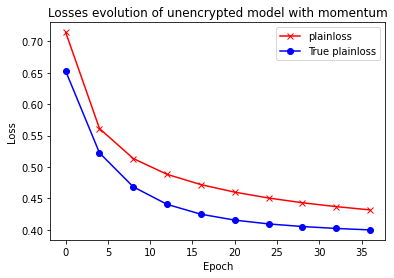

In [19]:
acc = unencrypted_model.accuracy(test_features.to_numpy(), test_labels.to_numpy().reshape((-1, 1)))
logging.info("Accuracy of unencrypted model : %s " % acc)

plt.plot([i*VERBOSE for i in range(len(unencrypted_model.loss_list))], 
         unencrypted_model.loss_list,'-xr',
         label='plainloss')
plt.plot([i*VERBOSE for i in range(len(unencrypted_model.true_loss_list))],
         unencrypted_model.true_loss_list,
         '-ob',
         label='True plainloss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses evolution of unencrypted model with momentum')
plt.legend(loc='best')

One can denote that the both curves are close. More important they evolve in the same way. 

# Training the crypted models

While training the model,we will probably need to make more computations than allowed by the safety parameters (here around 8 mutiplications are allowed before running out of scale). So in order to evaluate calculus circuit of arbitrary depth, one needs a "refresh" function, which reset this dept. To do so, we use the *unsafe* function refresh(), detailled before. In the next notebooks a communication protocole between Bob and Alice provides a safe way to perform this refresh step.

In [20]:
logging.info("Model initialization")
model = encrypted_LR.LogisticRegressionHE(init_weight=weight,
                                          init_bias=bias,
                                          refresh_function=refresh,
                                          context=context,
                                          confidential_kwarg=confidential_data,
                                          accuracy=accuracy,
                                          verbose=VERBOSE,
                                          save_weight=SAVE_WEIGHT,
                                          max_epoch=EPOCH,
                                          learning_rate=LEARNING_RATE,
                                          momentum_rate=MOMENTUM_RATE,
                                          reg_para=REGULARIZATION_RATE,
                                          n_jobs = N_JOBS)

08/04/2020 01:45:38 PM  [INFO    ]  Model initialization


In [21]:
logging.info("Training starting")
timer=time.time()
model.fit(encrypted_X, encrypted_Y)
logging.info("Training done. " + str(round(time.time() - timer, 0)) + " seconds")

08/04/2020 01:46:27 PM  [INFO    ]  Training starting
08/04/2020 01:46:27 PM  [INFO    ]  Starting serialization of data
08/04/2020 01:50:21 PM  [INFO    ]  Data serialization done in 234.05052828788757 seconds
08/04/2020 01:50:21 PM  [INFO    ]  Initialization of 8 workers
08/04/2020 01:50:29 PM  [INFO    ]  Initialization done for process Process-17. Len of data : 69
08/04/2020 01:50:29 PM  [INFO    ]  Initialization done for process Process-18. Len of data : 69
08/04/2020 01:50:30 PM  [INFO    ]  Initialization done for process Process-20. Len of data : 68
08/04/2020 01:50:30 PM  [INFO    ]  Initialization done for process Process-19. Len of data : 68
08/04/2020 01:50:30 PM  [INFO    ]  Initialization done for process Process-21. Len of data : 68
08/04/2020 01:50:30 PM  [INFO    ]  Initialization done for process Process-22. Len of data : 68
08/04/2020 01:50:30 PM  [INFO    ]  Initialization done for process Process-23. Len of data : 68
08/04/2020 01:50:31 PM  [INFO    ]  Initializa

# Evalution of the models

### Encrypted model

08/04/2020 02:45:10 PM  [INFO    ]  Precision score of encrypted model on test set: 0.84375 
08/04/2020 02:45:10 PM  [INFO    ]  Recall score  of encrypted model on test set : 0.7297297297297297 
08/04/2020 02:45:10 PM  [INFO    ]  F1 score of encrypted model on test set: 0.7826086956521738 
08/04/2020 02:45:10 PM  [INFO    ]  Accuracy of encrypted model on train set : 0.845360824742268 


<AxesSubplot:>

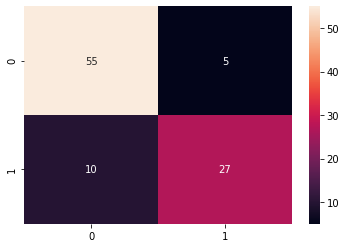

In [22]:
unencrypted_X = test_features.to_numpy()
weight = model.weight.decrypt(secret_key)
bias = model.bias.decrypt(secret_key)
re = unencrypted_X.dot(weight) + bias  
prediction = (np.float_power(re, 3)) * -0.004 + re * 0.197 + 0.5
prediction = 1*(prediction > 0.5)
recall = recall_score(test_labels,prediction)
F1 = f1_score(test_labels, prediction)
precision = precision_score(test_labels, prediction)
cf_m=confusion_matrix(test_labels, prediction ) 
accuracy = accuracy_score(test_labels, prediction)

logging.info("Precision score of encrypted model on test set: %s " % precision)
logging.info("Recall score  of encrypted model on test set : %s " % recall)
logging.info("F1 score of encrypted model on test set: %s " % F1)
logging.info("Accuracy of encrypted model on train set : %s " % accuracy)
sns.heatmap(cf_m, annot=True)

## Unencrypted homemade model

08/04/2020 02:45:10 PM  [INFO    ]  Precision score of unencrypted model on test set: 0.84375 
08/04/2020 02:45:10 PM  [INFO    ]  Recall score  of unencrypted model on test set : 0.7297297297297297 
08/04/2020 02:45:10 PM  [INFO    ]  F1 score of unencrypted model on test set: 0.7826086956521738 
08/04/2020 02:45:10 PM  [INFO    ]  Accuracy of unencrypted model on train set : 0.845360824742268 


<AxesSubplot:>

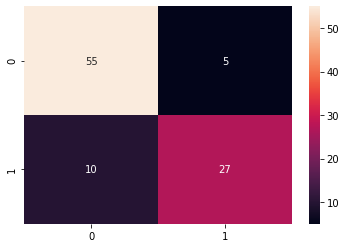

In [23]:
prediction = unencrypted_model.predict(test_features)
prediction = 1*(prediction > 0.5)
recall = recall_score(test_labels,prediction)
F1 = f1_score(test_labels, prediction)
precision = precision_score(test_labels, prediction)
cf_m=confusion_matrix(test_labels, prediction ) 
accuracy = accuracy_score(test_labels, prediction)

logging.info("Precision score of unencrypted model on test set: %s " % precision)
logging.info("Recall score  of unencrypted model on test set : %s " % recall)
logging.info("F1 score of unencrypted model on test set: %s " % F1)
logging.info("Accuracy of unencrypted model on train set : %s " % accuracy)
sns.heatmap(cf_m, annot=True)

## Scikit-learn model

08/04/2020 02:45:10 PM  [INFO    ]  Precision score of scikit-learn model on test set: 0.84375 
08/04/2020 02:45:10 PM  [INFO    ]  Recall score  of scikit-learn model on test set : 0.7297297297297297 
08/04/2020 02:45:10 PM  [INFO    ]  F1 score of scikit-learn model on test set: 0.7826086956521738 
08/04/2020 02:45:10 PM  [INFO    ]  Accuracy of scikit-learn model on test set : 0.845360824742268 


<AxesSubplot:>

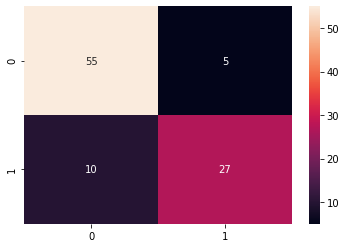

In [24]:
prediction = sk_model.predict(test_features)
prediction = 1*(prediction > 0.5)
recall = recall_score(test_labels,prediction)
F1 = f1_score(test_labels, prediction)
precision = precision_score(test_labels, prediction)
cf_m=confusion_matrix(test_labels, prediction ) 
accuracy = accuracy_score(test_labels, prediction)

logging.info("Precision score of scikit-learn model on test set: %s " % precision)
logging.info("Recall score  of scikit-learn model on test set : %s " % recall)
logging.info("F1 score of scikit-learn model on test set: %s " % F1)
logging.info("Accuracy of scikit-learn model on test set : %s " % accuracy)
sns.heatmap(cf_m, annot=True)

The homemade models gave rigourousy identical results, so homomorphic encryption cannot be blame. The model precision is not an issue. What is more an issue is the memory cost and the time complexity, which is really bigger for the encrypted model, even with multiprocessing. **CHIFFRER CES ECARTS**

# Figures

## encrypted and unencrypted losses 

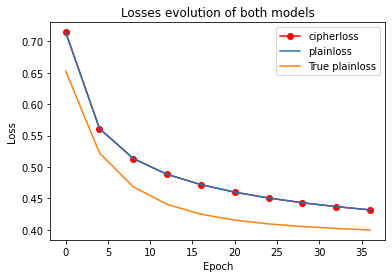

In [25]:
plt.plot([i*VERBOSE for i in range(len(model.loss_list))],
         [i.decrypt(secret_key)[0] for i in model.loss_list],
         '-or',
         label='cipherloss')

plt.plot([i*VERBOSE for i in range(len(unencrypted_model.loss_list))],
         unencrypted_model.loss_list, 
         label='plainloss')
plt.plot([i*VERBOSE for i in range(len(unencrypted_model.true_loss_list))],
         unencrypted_model.true_loss_list,
         label='True plainloss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses evolution of both models')
plt.legend(loc='best')

One can denotes that the cipherloss and the plainloss are superimposed. The only error is introduced by the polynomial approximations. 

## Unencrypted loss

# Errors

## Relative error between losses

In [26]:
decrypted = [i.decrypt(secret_key)[0] for i in model.loss_list]
true_err_cl = np.abs(np.array(decrypted) - np.array(unencrypted_model.loss_list))
rel_err_cl = true_err_cl/np.abs(decrypted)
true_err_ct = np.abs(np.array(decrypted) - np.array(unencrypted_model.true_loss_list))
rel_err_ct = true_err_ct/np.abs(decrypted)
true_err_lt = np.abs(np.array(unencrypted_model.loss_list) - np.array(unencrypted_model.true_loss_list))
rel_err_lt = true_err_lt/np.abs(unencrypted_model.true_loss_list)


Text(0.5, 1.0, 'Relative error between losses')

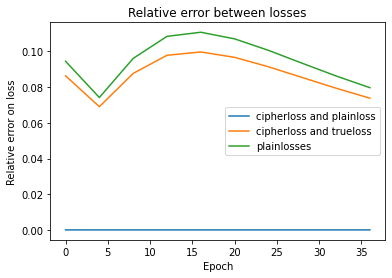

In [27]:
plt.plot([i*VERBOSE for i in range(len(model.loss_list))],  rel_err_cl, label='cipherloss and plainloss')
plt.plot([i*VERBOSE for i in range(len(model.loss_list))],  rel_err_ct, label='cipherloss and trueloss' )
plt.plot([i*VERBOSE for i in range(len(model.loss_list))],  rel_err_lt, label='plainlosses')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Relative error on loss')
plt.title('Relative error between losses')

## Relative error between weights

In [28]:
dwl = np.array([i.decrypt(secret_key) for i in model.weight_list])
dbl = np.array([i.decrypt(secret_key) for i in model.bias_list]).reshape((-1,1))
dl = np.concatenate((dwl,dbl), axis=1)

ul = np.concatenate(
    (np.array(unencrypted_model.weight_list),
     np.array(unencrypted_model.bias_list).reshape((-1,1))), axis=1)
w_err = np.mean((np.abs(dl-ul)/np.abs(ul)), axis=1)

Text(0.5, 1.0, 'Relative error between encrypted weights and unencrypted weights')

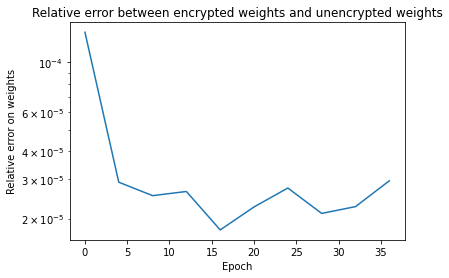

In [29]:
#plt.plot([i*VERBOSE for i in range(w_err.shape[0])],wm_err)
plt.plot([i*VERBOSE for i in range(w_err.shape[0])],w_err)
#plt.plot([i*VERBOSE for i in range(w_err.shape[0])],w2_err)

plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Relative error on weights')
plt.title('Relative error between encrypted weights and unencrypted weights')

With a relative error of $10^{-4}$, we can validate the precision of the encryption scheme. This precision is really related to our encryption parameter. It is interesting to observe the result with different parameters. 

In [30]:
del encrypted_X, encrypted_Y # to free memory 

### Comments on multiprocessing

For each sub-process, Linux creates (forks) a child process, with its own and closed memory space, as a copy of the parent process. So in theory, the children has a copy of all variables of the parent in its own memory. To save space, Linux use a system of copy-on-write. The principe is that the child process sees in its virtual memory all variables that were in the memory space of parent process when the children is created. But Linux does copy the variable from the parent's memory to the child's memory only the first time the children try to write on the variable. 
With tenseal, CKKSvector and context cannot be copied with this principle, because the "copy" use the pickle serialization, which is not allowed by tenseal. 

To avoid this problem, I initialize my N processes by passing a function init(), which takes as parameters the context in binary, and 1/N of the data, in binary. The init() function creates global variables for the context and the dataset, calling the context_from() and ckks_vector_from(). As the init() function is executed locally by the porcess, the global variables are created in the process memory. Them, at each epoch I serialize the weight in the parent process, pass it though a queue to each process. Processes deserialize the weight, using their local context, compute the gradient on their local dataset, ser it, and put the serialized gradient to a queue to give it back to the parent process. The parent process will then (first deserialize the gradients) sums the partial gradients, to get the final gradient, and the descent direction, so as to eventually actualize the weight and bias. And I iterate thought the epochs

As a result we got strange memory profiles for ours processes. Our virtual memory occuped is far above our physical memory, as is our RES memory. It can be explained by the "shared" part of the memory, copie of the parent process, which in never called.

This caption shows the state of memory and cpu use before the creation of the workers. The data and the context have been serialized

The memory load is quite low and one CPU is ending serialization

This caption shows the state of memory and cpu use before the creation of the workers. The data and the context have been serialized

The memory load is quite low and one CPU is ending serialization

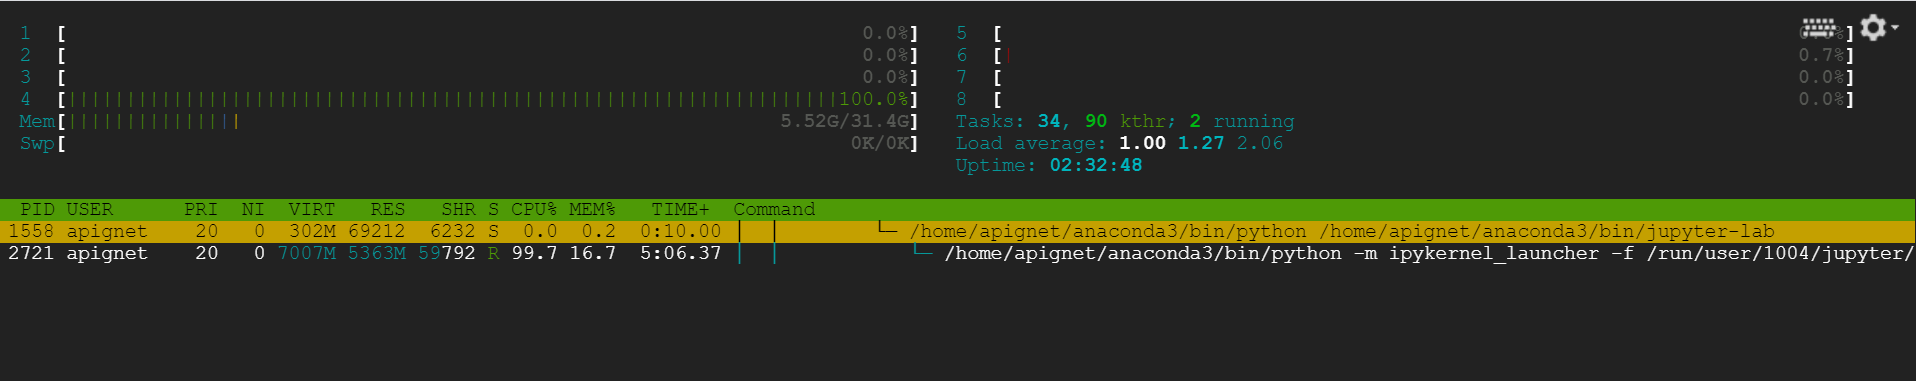

Here the 8 processes have been created and are computing some gradients. The sum of VIR memory and RES meory is far more then the actual 18.7 Gb used. 

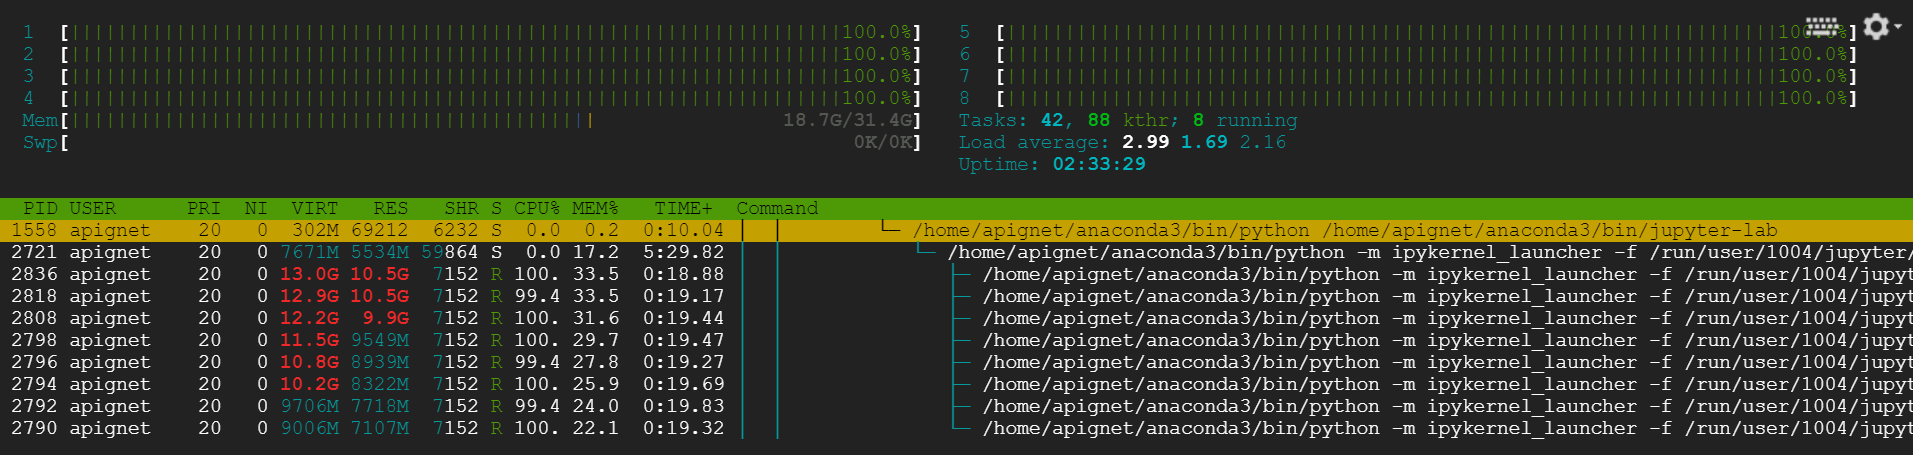

And finally, after the storage of some temp weights and bias, and loss values, we ended with this results. 

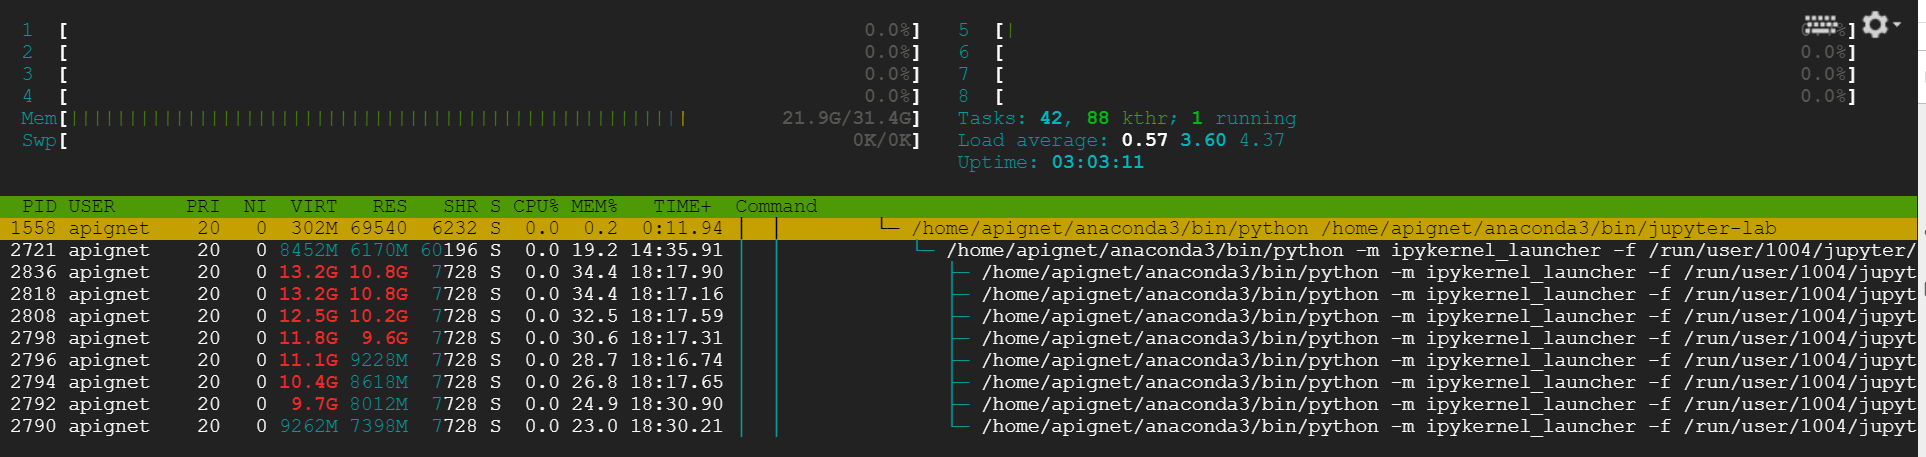

## Making kaggle submission files for the 3 models

###  Scikit learn model

In [15]:
proba_predictions = sk_model.predict(submission_test)

array([0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 1.

In [17]:
submission_pred = 1*(np.array(proba_predictions) > 0.5)
submission_df = pd.DataFrame({
        "PassengerId": raw_test["PassengerId"],
        "Survived": submission_pred.reshape(-1)
    })
submission_df.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [18]:
submission_df.to_csv(SUBMISSION_PATH+'submission_sk_learn.csv', index=False)

### Unencrypted homemade model

In [ ]:
proba_predictions = unencrypted_model.predict(submission_test.to_numpy().tolist())

In [ ]:
submission_pred = 1*(np.array(proba_predictions) > 0.5)
submission_df = pd.DataFrame({
        "PassengerId": raw_test["PassengerId"],
        "Survived": submission_pred.reshape(-1)
    })
submission_df.head()

In [ ]:
submission_df.to_csv(SUBMISSION_PATH+'submission_unenc_model.csv', index=False)

### Encrypted homemade model

In [ ]:
proba_predictions = model.predict(submission_test.to_numpy().tolist())

In [ ]:
submission_pred = 1*(np.array(proba_predictions) > 0.5)
submission_df = pd.DataFrame({
        "PassengerId": raw_test["PassengerId"],
        "Survived": submission_pred.reshape(-1)
    })
submission_df.head()

In [ ]:
submission_df.to_csv(SUBMISSION_PATH+'submission_enc_model.csv', index=False)